In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [2]:
import torch, numpy as np
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import OxfordIIITPet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = (128, 128)

transform_img = T.Compose([
    T.Resize(input_size),
    T.ToTensor()
])

transform_mask = T.Compose([
    T.Resize(input_size, interpolation=T.InterpolationMode.NEAREST),
    T.PILToTensor(),                                # shape [1,H,W], values 1..3
    T.Lambda(lambda t: (t - 1).clamp(0, 2).long())  # -> 0..2, dtype long
])

dataset = OxfordIIITPet(root='data', split='trainval', target_types='segmentation',
                        transform=transform_img, target_transform=transform_mask, download=True)
test_dataset = OxfordIIITPet(root='data', split='test', target_types='segmentation',
                             transform=transform_img, target_transform=transform_mask, download=True)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2 if device.type=='cuda' else 0)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=2 if device.type=='cuda' else 0)

len(dataset), len(test_dataset), len(train_dataset), len(val_dataset)


100%|██████████| 792M/792M [00:39<00:00, 20.0MB/s]
100%|██████████| 19.2M/19.2M [00:08<00:00, 2.28MB/s]


(3680, 3669, 2944, 736)

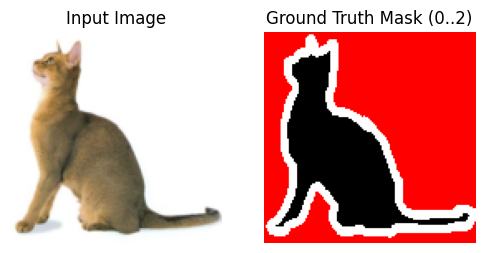

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'red', 'white'])  # 0=bg, 1=border, 2=pet

sample_img, sample_mask = train_dataset[1]
mask_array = sample_mask.squeeze().cpu().numpy().astype(np.uint8)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.title("Input Image"); plt.imshow(sample_img.permute(1,2,0)); plt.axis('off')
plt.subplot(1,2,2); plt.title("Ground Truth Mask (0..2)"); plt.imshow(mask_array, cmap=cmap, vmin=0, vmax=2); plt.axis('off')
plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop)
        )
    def forward(self, x): return self.net(x)

class UpBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        # after concat we have out_c (from up) + skip_c (which we design to equal out_c)
        self.conv = ConvBlock(in_c=out_c*2, out_c=out_c)
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class UNetMedium(nn.Module):
    """
    Depth 4 (down x3 + bottleneck + up x3)
    Enc: 32 -> 64 -> 128
    Bottleneck: 256
    Dec: mirror back to 32
    """
    def __init__(self, n_classes=3, in_ch=3, p_drop=0.1):
        super().__init__()
        # encoder
        self.enc1 = ConvBlock(in_ch, 32, p_drop)     # H x W
        self.pool1 = nn.MaxPool2d(2)                 # H/2
        self.enc2 = ConvBlock(32, 64, p_drop)        # H/2
        self.pool2 = nn.MaxPool2d(2)                 # H/4
        self.enc3 = ConvBlock(64, 128, p_drop)       # H/4
        self.pool3 = nn.MaxPool2d(2)                 # H/8
        # bottleneck
        self.bott = ConvBlock(128, 256, p_drop)      # H/8
        # decoder
        self.up3 = UpBlock(256, 128)                 # -> H/4, concat enc3
        self.up2 = UpBlock(128, 64)                  # -> H/2, concat enc2
        self.up1 = UpBlock(64, 32)                   # -> H,   concat enc1
        # head
        self.outc = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x, return_feats=False):
        s1 = self.enc1(x)        # [B, 32, H,   W]
        p1 = self.pool1(s1)      # [B, 32, H/2, W/2]
        s2 = self.enc2(p1)       # [B, 64, H/2, W/2]
        p2 = self.pool2(s2)      # [B, 64, H/4, W/4]
        s3 = self.enc3(p2)       # [B,128, H/4, W/4]
        p3 = self.pool3(s3)      # [B,128, H/8, W/8]
        b  = self.bott(p3)       # [B,256, H/8, W/8]

        d3 = self.up3(b, s3)     # [B,128, H/4, W/4]
        d2 = self.up2(d3, s2)    # [B, 64, H/2, W/2]
        d1 = self.up1(d2, s1)    # [B, 32, H,   W]
        out = self.outc(d1)      # [B,  3, H,   W]

        if return_feats:
            return out, dict(enc1=s1, enc2=s2, enc3=s3, bott=b, dec3=d3, dec2=d2, dec1=d1)
        return out

# ---- loss: CE + Dice (same as before)
class DiceLossMC(nn.Module):
    def __init__(self, num_classes, smooth=1.0, eps=1e-7):
        super().__init__()
        self.num_classes, self.smooth, self.eps = num_classes, smooth, eps
    def forward(self, logits, target):                 # logits [B,C,H,W], target [B,H,W]
        probs = F.softmax(logits, dim=1)
        target_oh = F.one_hot(target, num_classes=self.num_classes).permute(0,3,1,2).float()
        dims = (0,2,3)
        inter = (probs * target_oh).sum(dims)
        union = probs.sum(dims) + target_oh.sum(dims)
        dice = (2*inter + self.smooth) / (union + self.smooth + self.eps)
        return 1 - dice.mean()

model = UNetMedium(n_classes=3).to(device)


w_bg, w_border, w_pet = 0.5, 2.0, 1.5
ce_loss   = nn.CrossEntropyLoss(weight=torch.tensor([w_bg, w_border, w_pet], device=device))
dice_loss = DiceLossMC(num_classes=3)

def loss_fn(logits, y):
    return ce_loss(logits, y) + 0.5 * dice_loss(logits, y)


In [5]:
import torch, time
from torch.cuda.amp import autocast, GradScaler

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scaler = GradScaler(enabled=(device.type=='cuda'))

def train_epoch():
    model.train()
    tot = 0.0
    for x, y in train_loader:
        x = x.to(device)
        y = y.squeeze(1).long().to(device)          # [B,H,W] in 0..2
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device.type=='cuda')):
            logits = model(x)
            loss = loss_fn(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        tot += loss.item()
    return tot / max(1, len(train_loader))

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    tot = 0.0
    for x, y in loader:
        x = x.to(device)
        y = y.squeeze(1).long().to(device)
        logits = model(x)
        tot += loss_fn(logits, y).item()
    return tot / max(1, len(loader))

EPOCHS = 60
best = 1e9
for e in range(1, EPOCHS+1):
    t0 = time.time()
    tr = train_epoch()
    va = eval_epoch(val_loader)
    print(f"Epoch {e:02d} | train {tr:.4f} | val {va:.4f} | {time.time()-t0:.1f}s")
    if va < best:
        best = va
        torch.save(model.state_dict(), "unet_small_best.pt")

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black','red','white'])

def show_batch_preds(ds, n=3):
    model.eval()
    for i in range(n):
        img, mask = ds[i]
        x = img.unsqueeze(0).to(device)
        logits, feats = model(x, return_feats=True)   # get features if you want to visualize
        pred = logits.argmax(1).squeeze(0).cpu().numpy().astype('uint8')
        gt   = mask.squeeze().cpu().numpy().astype('uint8')
        fig, ax = plt.subplots(1,3, figsize=(9,3))
        ax[0].set_title("Input"); ax[0].imshow(img.permute(1,2,0)); ax[0].axis('off')
        ax[1].set_title("Ground Truth"); ax[1].imshow(gt, cmap=cmap, vmin=0, vmax=2); ax[1].axis('off')
        ax[2].set_title("Predicted"); ax[2].imshow(pred, cmap=cmap, vmin=0, vmax=2); ax[2].axis('off')
        plt.show()



/tmp/ipython-input-1404744200.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type=='cuda'))
/tmp/ipython-input-1404744200.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=='cuda')):


Epoch 01 | train 0.9214 | val 0.8771 | 21.7s
Epoch 02 | train 0.6865 | val 0.6659 | 17.2s
Epoch 03 | train 0.6110 | val 0.7138 | 17.2s
Epoch 04 | train 0.5701 | val 0.6799 | 18.3s
Epoch 05 | train 0.5208 | val 0.5462 | 17.4s
Epoch 06 | train 0.5038 | val 0.4898 | 17.6s
Epoch 07 | train 0.4740 | val 0.4711 | 17.8s
Epoch 08 | train 0.4482 | val 0.4485 | 17.2s
Epoch 09 | train 0.4349 | val 0.4409 | 18.3s
Epoch 10 | train 0.4238 | val 0.4623 | 17.1s
Epoch 11 | train 0.4079 | val 0.4172 | 17.1s
Epoch 12 | train 0.3994 | val 0.4412 | 18.1s
Epoch 13 | train 0.3889 | val 0.4524 | 17.1s
Epoch 14 | train 0.3710 | val 0.4243 | 17.5s
Epoch 15 | train 0.3651 | val 0.4230 | 17.8s
Epoch 16 | train 0.3459 | val 0.4014 | 17.3s
Epoch 17 | train 0.3427 | val 0.4328 | 18.1s
Epoch 18 | train 0.3313 | val 0.4034 | 17.3s
Epoch 19 | train 0.3231 | val 0.4287 | 17.2s
Epoch 20 | train 0.3117 | val 0.4005 | 18.2s
Epoch 21 | train 0.2992 | val 0.3909 | 17.2s
Epoch 22 | train 0.2929 | val 0.3924 | 18.0s
Epoch 23 |

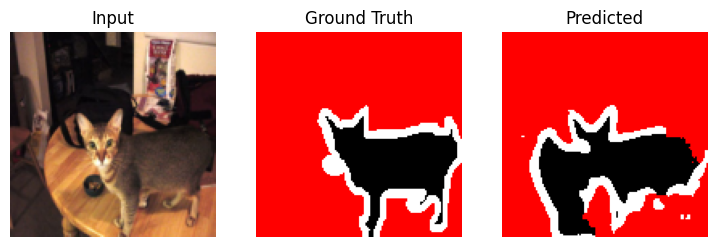

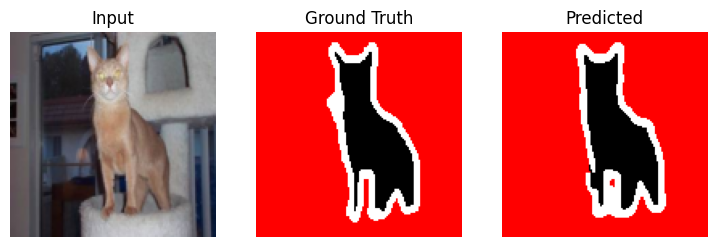

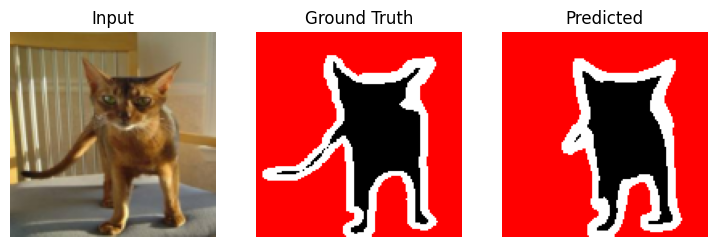

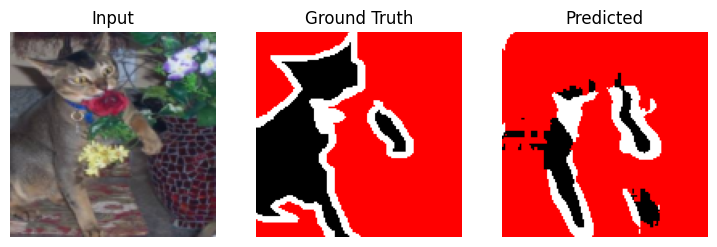

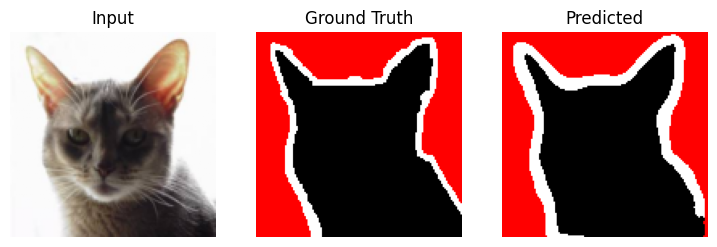

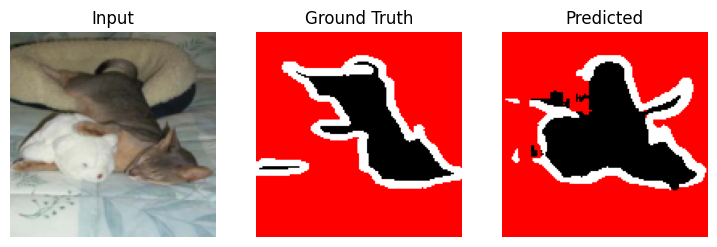

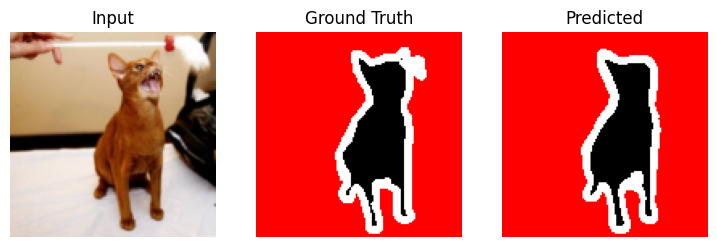

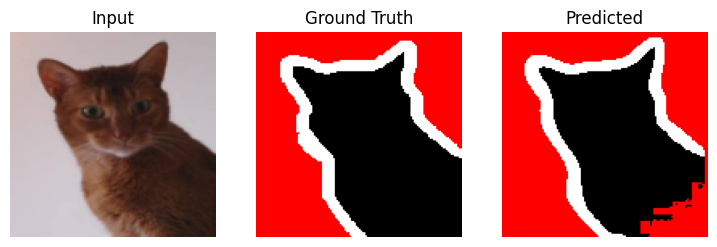

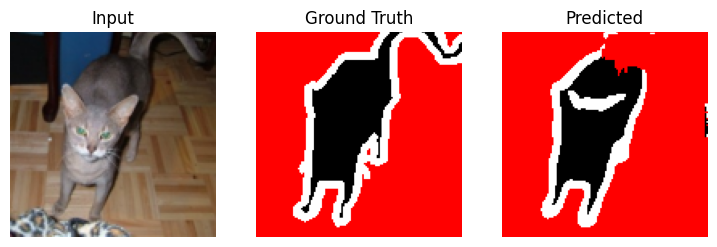

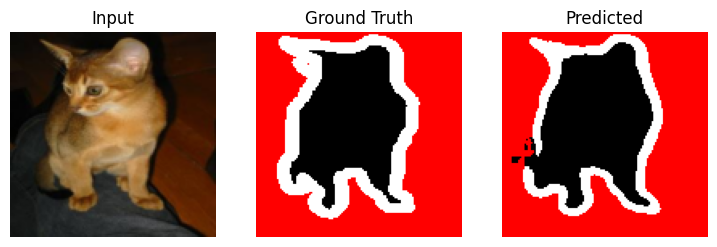

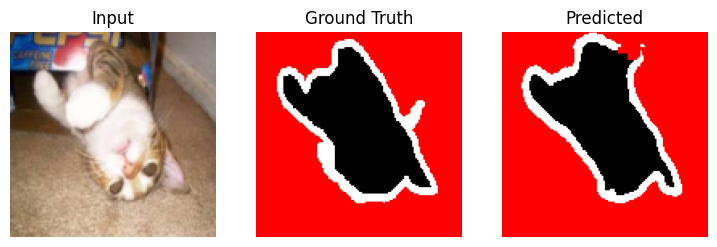

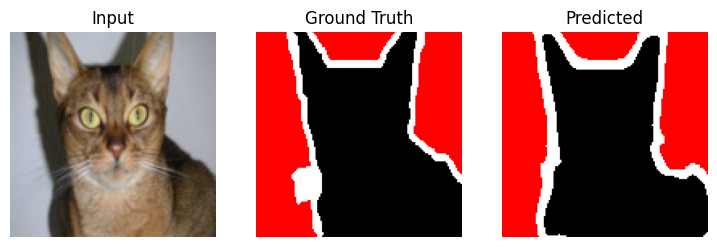

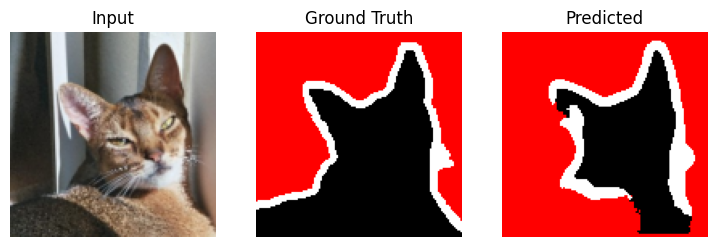

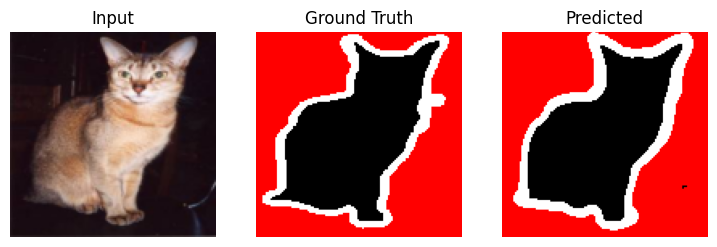

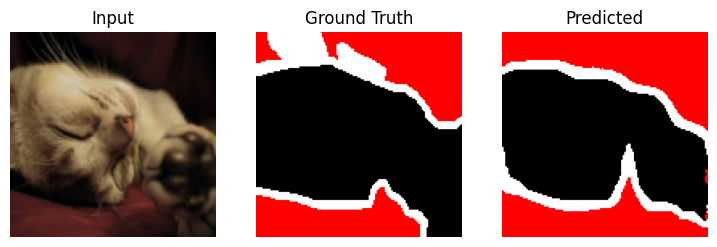

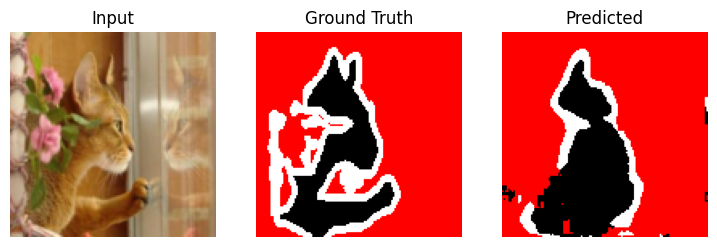

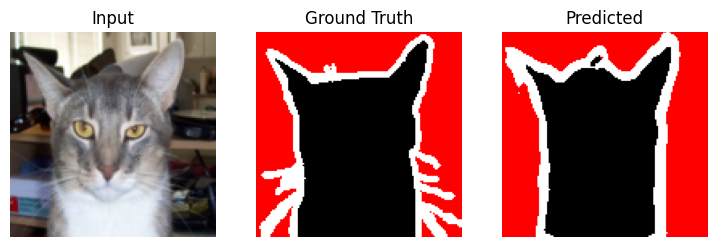

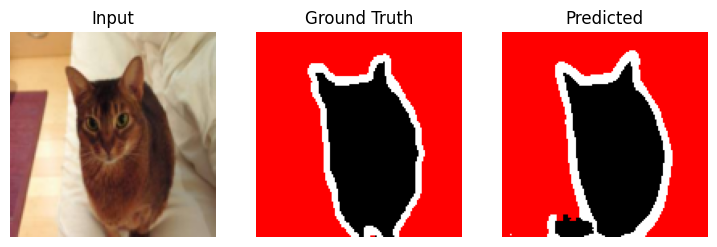

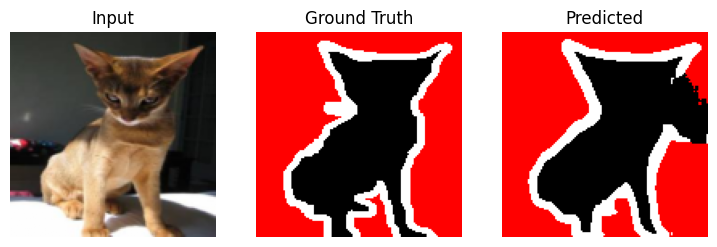

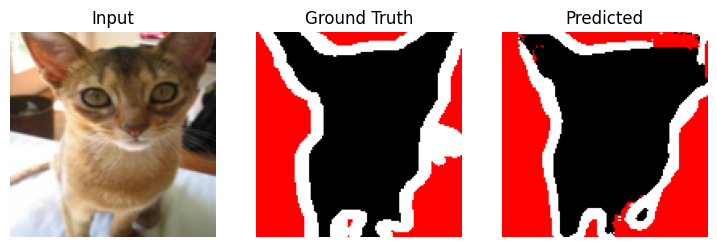

In [6]:
show_batch_preds(test_dataset, n=20)

In [7]:
import numpy as np, matplotlib.pyplot as plt, torch
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['black','red','white'])

def _to_numpy_img(x_1x3hw):
    return x_1x3hw.detach().cpu().squeeze(0).permute(1,2,0).numpy()

def _norm01(arr, eps=1e-6):
    return (arr - arr.min()) / (arr.max() - arr.min() + eps)

def visualize_feature_map(feature_tensor, title, max_channels=16, channels=None, tight=True):
    """
    Show channels from a feature map [1, C, H, W] as a grid.
    - max_channels: cap the number of channels shown
    - channels: list/tuple of channel indices to visualize (overrides max_channels if provided)
    """
    ft = feature_tensor.detach().cpu().squeeze(0)  # [C,H,W]
    C = ft.shape[0]
    if channels is None:
        Cshow = min(C, max_channels)
        ch_idx = list(range(Cshow))
    else:
        ch_idx = [i for i in channels if 0 <= i < C]
        Cshow = len(ch_idx)
    cols = int(np.ceil(np.sqrt(Cshow)))
    rows = int(np.ceil(Cshow / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    fig.suptitle(f"{title}  (feat shape: {tuple(feature_tensor.shape)})", fontsize=12)
    axes = np.atleast_1d(axes).ravel()
    for i in range(rows*cols):
        ax = axes[i]
        ax.axis('off')
        if i < Cshow:
            fm = ft[ch_idx[i]].numpy()
            ax.imshow(_norm01(fm), cmap='gray')
            ax.set_title(f"ch {ch_idx[i]}", fontsize=8)
    if tight: plt.tight_layout()
    plt.show()

def overlay_activation(rgb, fmap, title, reduce='mean'):
    """
    Heatmap overlay: reduce over channels of fmap on top of input image.
    reduce: 'mean' or 'max'
    rgb: [1,3,H,W], fmap: [1,C,H,W]
    """
    img = _to_numpy_img(rgb)
    ft = fmap.detach().cpu().squeeze(0)  # [C,H,W]
    if reduce == 'max':
        act = ft.max(0).values.numpy()
    else:
        act = ft.mean(0).numpy()
    act = _norm01(act)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.title("Input"); plt.imshow(img); plt.axis('off')
    plt.subplot(1,2,2); plt.title(title)
    plt.imshow(img); plt.imshow(act, alpha=0.45, cmap='jet'); plt.axis('off')
    plt.show()

def visualize_concat(up, skip, concat, title, k_each=6):
    """
    Show a few channels from:
      row 1: upsampled decoder feature (pre-concat)
      row 2: encoder skip
      row 3: concatenated tensor (channels are [up..., skip...])
    """
    upC, skC = up.shape[1], skip.shape[1]
    k_up = min(k_each, upC)
    k_sk = min(k_each, skC)
    # Prepare panels
    panels = [up[:, i:i+1] for i in range(k_up)] + [skip[:, i:i+1] for i in range(k_sk)]
    labels = [f"up {i}" for i in range(k_up)] + [f"skip {i}" for i in range(k_sk)]
    # concat first (k_up + k_sk) channels
    k_cat = min(k_up + k_sk, concat.shape[1])
    panels += [concat[:, i:i+1] for i in range(k_cat)]
    labels += [f"cat {i}" for i in range(k_cat)]

    n = len(panels)
    cols = max(k_each, 3)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*2, rows*2))
    plt.suptitle(f"{title}\nup:{tuple(up.shape)}  skip:{tuple(skip.shape)}  concat:{tuple(concat.shape)}", fontsize=11)
    for idx, tens in enumerate(panels):
        plt.subplot(rows, cols, idx+1)
        fm = tens.detach().cpu().squeeze().numpy()
        plt.imshow(_norm01(fm), cmap='gray'); plt.axis('off'); plt.title(labels[idx], fontsize=8)
    plt.tight_layout()
    plt.show()

def show_prediction(model, sample_img, sample_mask, show_confidence=True):
    """
    3 (or 4)-panel: input | GT | Pred (| confidence of top-class)
    """
    x = sample_img.to(device).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs  = torch.softmax(logits, dim=1)  # [1,C,H,W]
        pred   = probs.argmax(1).squeeze(0).cpu().numpy().astype('uint8')
        conf   = probs.max(1).values.squeeze(0).cpu().numpy()  # confidence of top class

    img_np = sample_img.permute(1,2,0).cpu().numpy()
    gt = sample_mask.squeeze().cpu().numpy().astype('uint8')

    ncols = 4 if show_confidence else 3
    plt.figure(figsize=(3*ncols,3))
    plt.subplot(1,ncols,1); plt.title("Input"); plt.imshow(img_np); plt.axis('off')
    plt.subplot(1,ncols,2); plt.title("Ground Truth"); plt.imshow(gt, cmap=cmap, vmin=0, vmax=2); plt.axis('off')
    plt.subplot(1,ncols,3); plt.title("Predicted"); plt.imshow(pred, cmap=cmap, vmin=0, vmax=2); plt.axis('off')
    if show_confidence:
        plt.subplot(1,ncols,4); plt.title("Top-class confidence")
        plt.imshow(_norm01(conf), cmap='magma'); plt.axis('off')
    plt.show()


Shapes:
s1: (1, 32, 128, 128)
s2: (1, 64, 64, 64)
s3: (1, 128, 32, 32)
b : (1, 256, 16, 16)
d3: (1, 128, 32, 32)
d2: (1, 64, 64, 64)
d1: (1, 32, 128, 128)


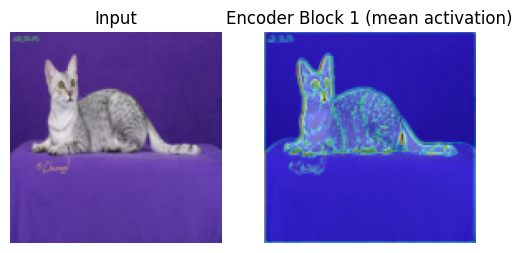

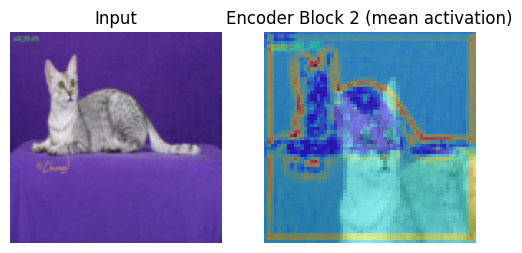

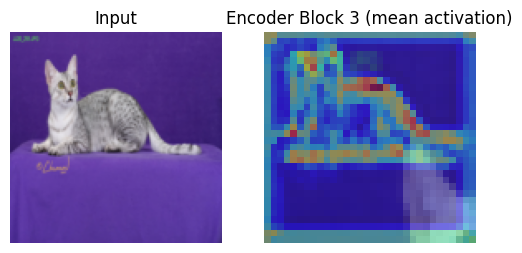

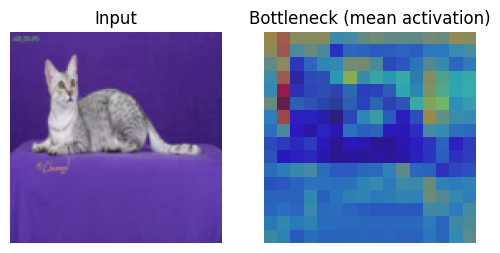

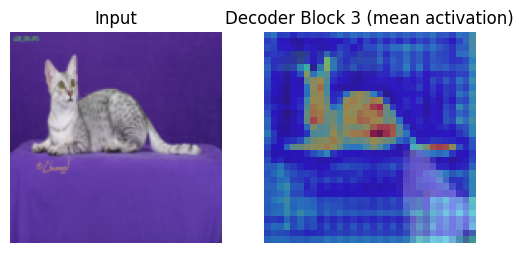

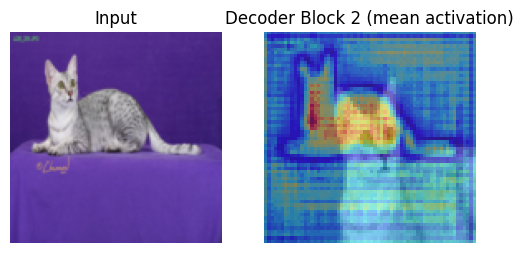

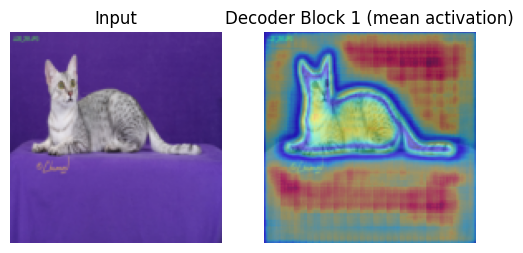

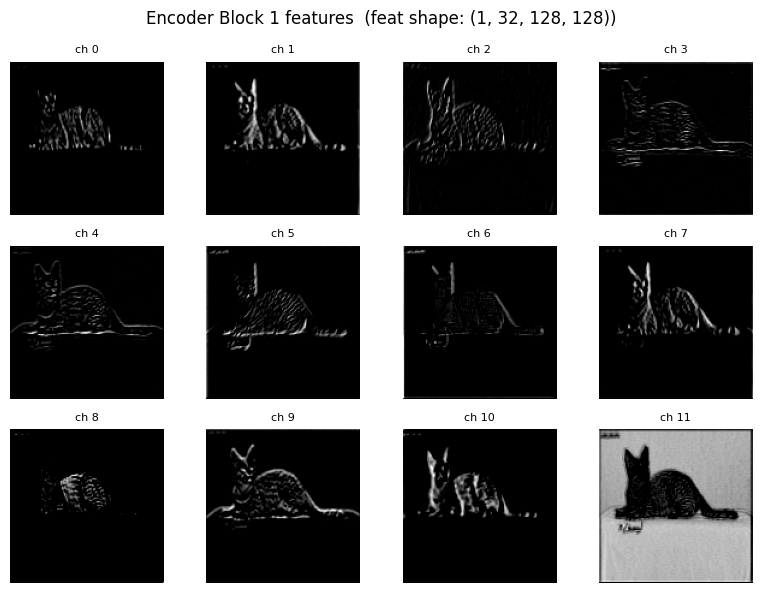

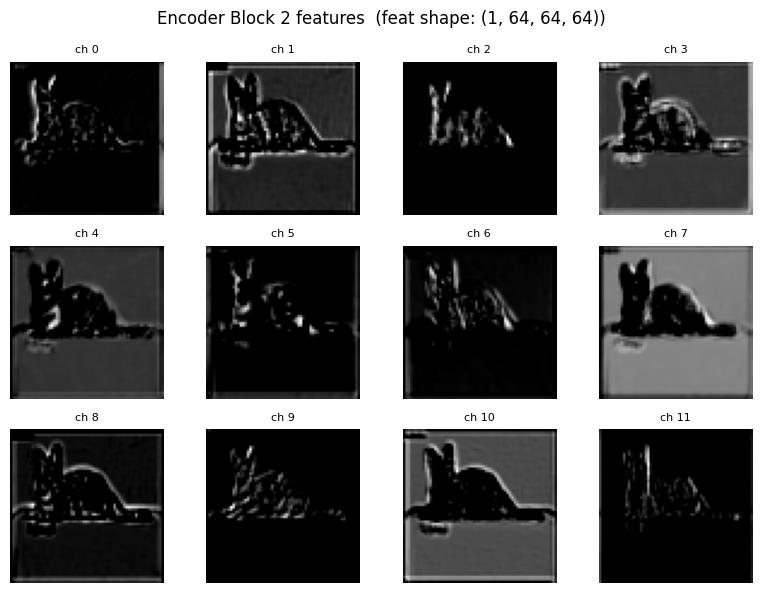

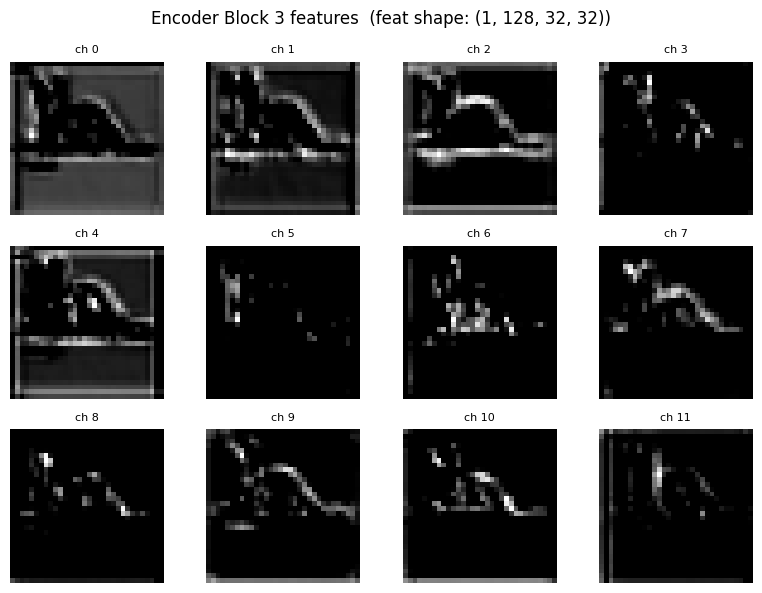

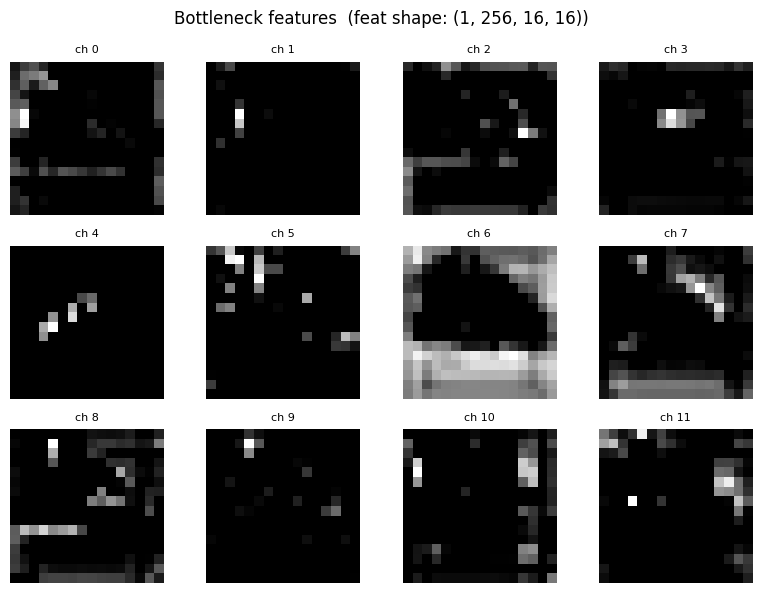

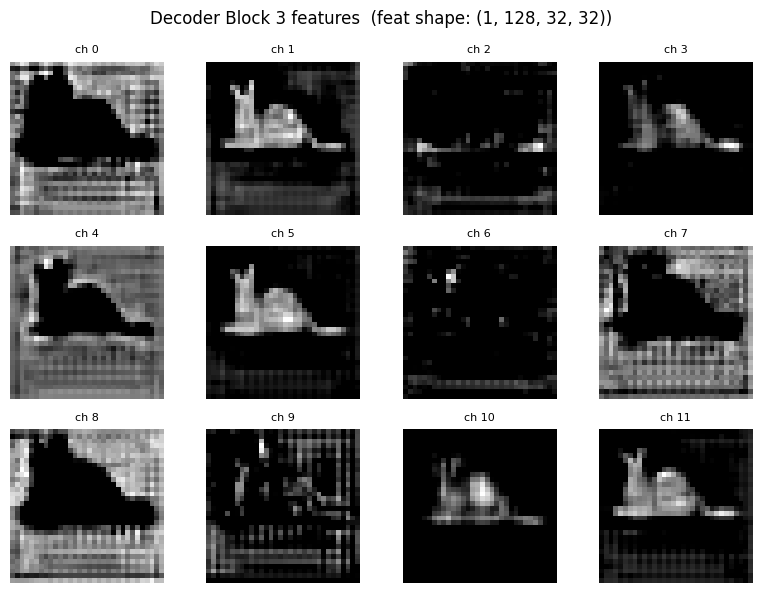

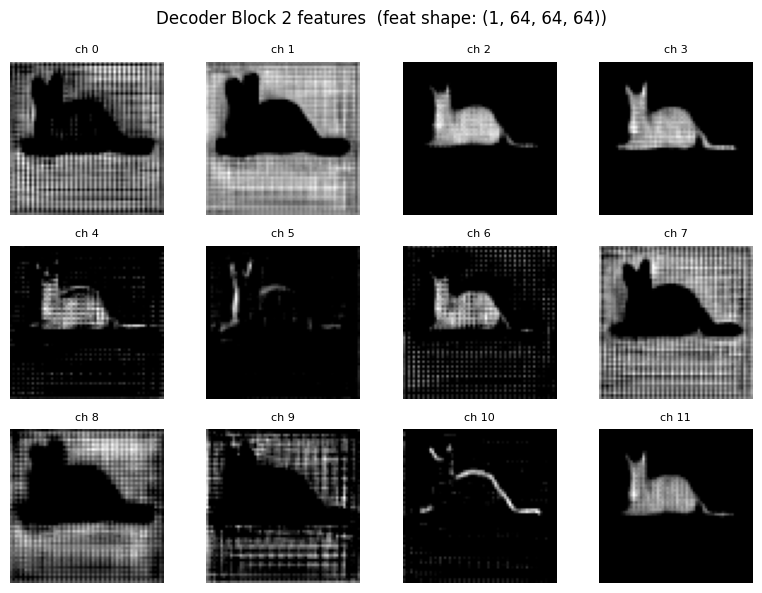

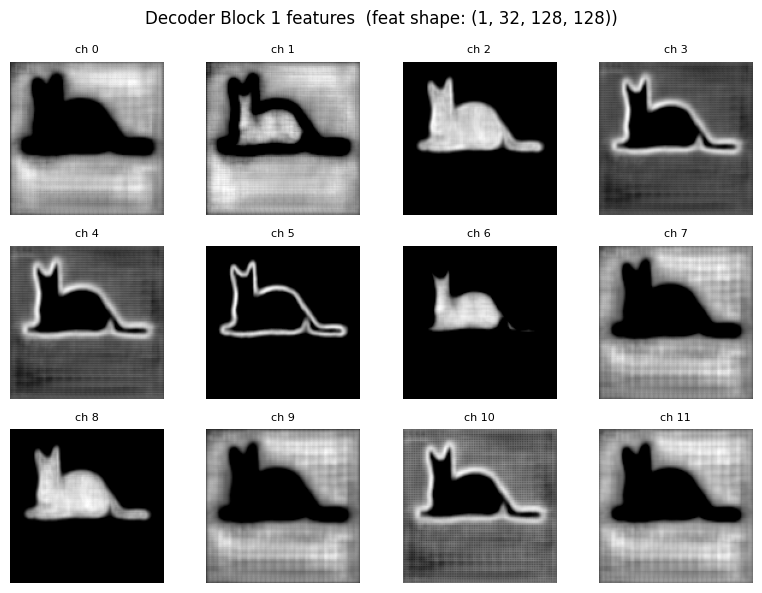

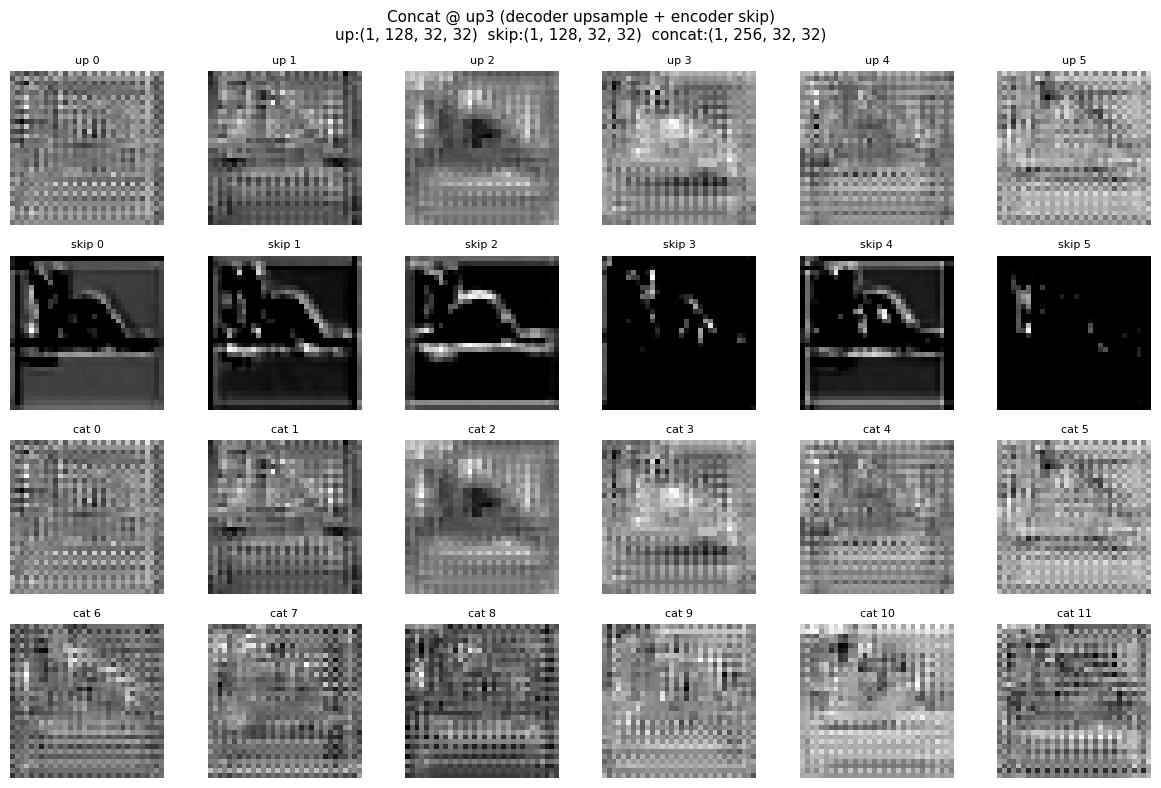

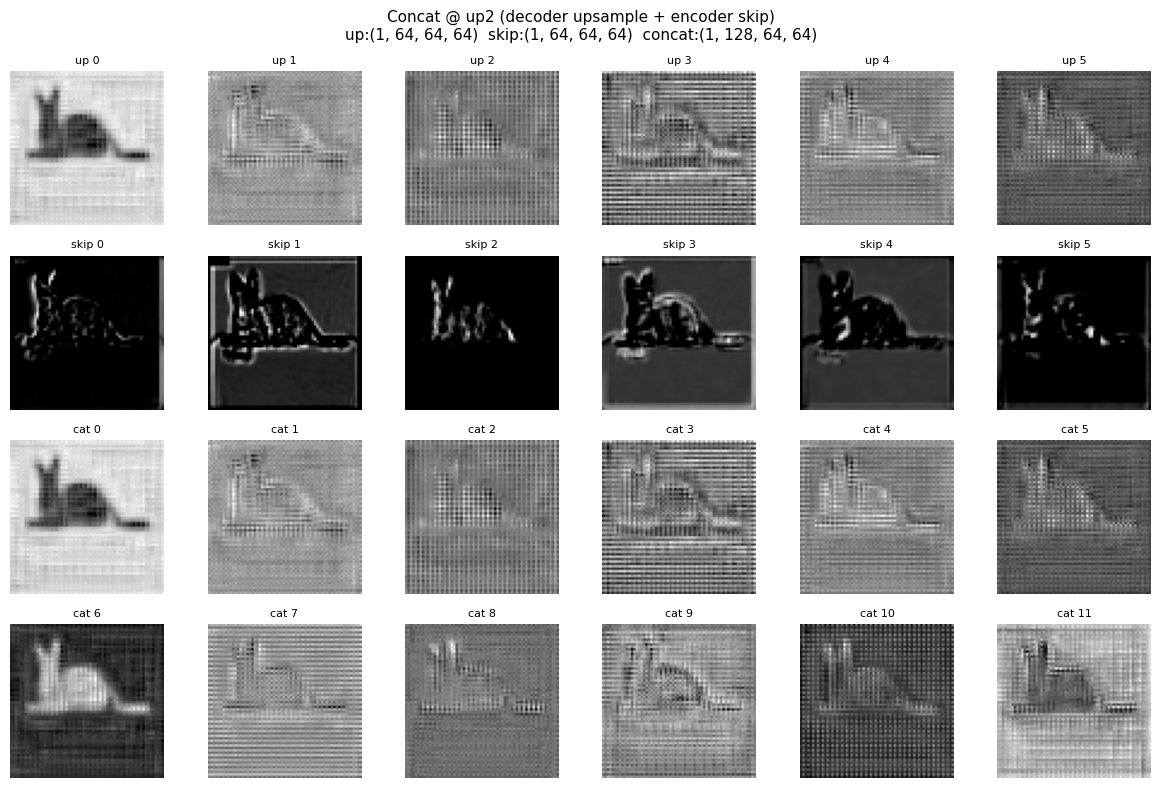

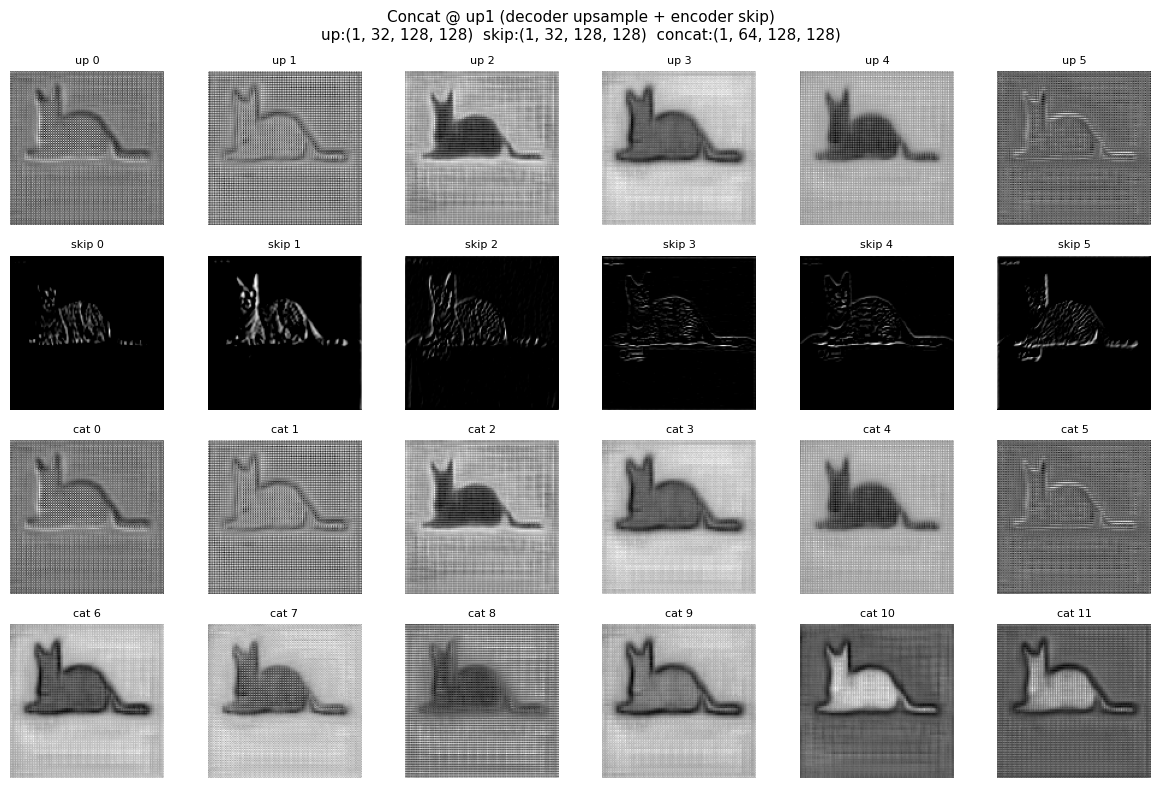

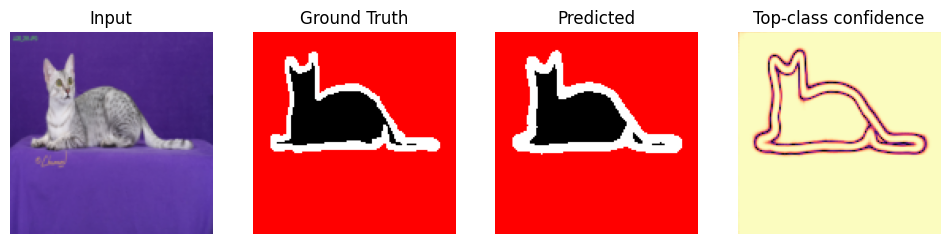

In [8]:
model.eval()
img, mask = val_dataset[2]   # try different indices too
x = img.unsqueeze(0).to(device)

with torch.no_grad():
    s1 = model.enc1(x)        # [B, 32, H,   W]
    p1 = model.pool1(s1)      # [B, 32, H/2, W/2]

    s2 = model.enc2(p1)       # [B, 64, H/2, W/2]
    p2 = model.pool2(s2)      # [B, 64, H/4, W/4]

    has_level3 = hasattr(model, 'enc3') and hasattr(model, 'pool3') and hasattr(model, 'up3')

    if has_level3:
        s3 = model.enc3(p2)   # [B,128, H/4, W/4]
        p3 = model.pool3(s3)  # [B,128, H/8, W/8]
        b  = model.bott(p3)   # [B,256, H/8, W/8]

        u3_pre = model.up3.up(b)              # [B,128, H/4, W/4]
        if u3_pre.shape[-2:] != s3.shape[-2:]:
            u3_pre = torch.nn.functional.interpolate(u3_pre, size=s3.shape[-2:], mode="bilinear", align_corners=False)
        cat3 = torch.cat([u3_pre, s3], 1)     # [B,256, H/4, W/4]
        d3   = model.up3.conv(cat3)           # [B,128, H/4, W/4]

        u2_pre = model.up2.up(d3)             # [B,64, H/2, W/2]
        if u2_pre.shape[-2:] != s2.shape[-2:]:
            u2_pre = torch.nn.functional.interpolate(u2_pre, size=s2.shape[-2:], mode="bilinear", align_corners=False)
        cat2 = torch.cat([u2_pre, s2], 1)     # [B,128, H/2, W/2]
        d2   = model.up2.conv(cat2)           # [B,64, H/2, W/2]

        u1_pre = model.up1.up(d2)             # [B,32, H, W]
        if u1_pre.shape[-2:] != s1.shape[-2:]:
            u1_pre = torch.nn.functional.interpolate(u1_pre, size=s1.shape[-2:], mode="bilinear", align_corners=False)
        cat1 = torch.cat([u1_pre, s1], 1)     # [B,64, H, W]
        d1   = model.up1.conv(cat1)           # [B,32, H, W]

        logits = model.outc(d1)               # [B,3,H,W]

    else:
        b  = model.bott(p2)                   # [B,128, H/4, W/4]

        u1_pre = model.up1.up(b)              # [B,64, H/2, W/2]
        if u1_pre.shape[-2:] != s2.shape[-2:]:
            u1_pre = torch.nn.functional.interpolate(u1_pre, size=s2.shape[-2:], mode="bilinear", align_corners=False)
        cat1 = torch.cat([u1_pre, s2], 1)     # [B,128, H/2, W/2]
        d1   = model.up1.conv(cat1)           # [B,64, H/2, W/2]

        u2_pre = model.up2.up(d1)             # [B,32, H, W]
        if u2_pre.shape[-2:] != s1.shape[-2:]:
            u2_pre = torch.nn.functional.interpolate(u2_pre, size=s1.shape[-2:], mode="bilinear", align_corners=False)
        cat2 = torch.cat([u2_pre, s1], 1)     # [B,64, H, W]
        d2   = model.up2.conv(cat2)           # [B,32, H, W]

        logits = model.outc(d2)               # [B,3,H,W]

print("Shapes:")
print("s1:", tuple(s1.shape))
print("s2:", tuple(s2.shape))
if has_level3: print("s3:", tuple(s3.shape))
print("b :", tuple(b.shape))
if has_level3:
    print("d3:", tuple(d3.shape))
    print("d2:", tuple(d2.shape))
    print("d1:", tuple(d1.shape))
else:
    print("d1:", tuple(d1.shape))
    print("d2:", tuple(d2.shape))

overlay_activation(x, s1, "Encoder Block 1 (mean activation)")
overlay_activation(x, s2, "Encoder Block 2 (mean activation)")
if has_level3: overlay_activation(x, s3, "Encoder Block 3 (mean activation)")
overlay_activation(x, b,  "Bottleneck (mean activation)")
if has_level3:
    overlay_activation(x, d3, "Decoder Block 3 (mean activation)")
    overlay_activation(x, d2, "Decoder Block 2 (mean activation)")
    overlay_activation(x, d1, "Decoder Block 1 (mean activation)")
else:
    overlay_activation(x, d1, "Decoder Block 2 (mean activation)")
    overlay_activation(x, d2, "Decoder Block 1 (mean activation)")

visualize_feature_map(s1, "Encoder Block 1 features", max_channels=12)
visualize_feature_map(s2, "Encoder Block 2 features", max_channels=12)
if has_level3: visualize_feature_map(s3, "Encoder Block 3 features", max_channels=12)
visualize_feature_map(b,  "Bottleneck features",      max_channels=12)
if has_level3:
    visualize_feature_map(d3, "Decoder Block 3 features", max_channels=12)
    visualize_feature_map(d2, "Decoder Block 2 features", max_channels=12)
    visualize_feature_map(d1, "Decoder Block 1 features", max_channels=12)
else:
    visualize_feature_map(d1, "Decoder Block 2 features", max_channels=12)
    visualize_feature_map(d2, "Decoder Block 1 features", max_channels=12)

if has_level3:
    visualize_concat(u3_pre, s3, cat3, title="Concat @ up3 (decoder upsample + encoder skip)")
    visualize_concat(u2_pre, s2, cat2, title="Concat @ up2 (decoder upsample + encoder skip)")
    visualize_concat(u1_pre, s1, cat1, title="Concat @ up1 (decoder upsample + encoder skip)")
else:
    visualize_concat(u1_pre, s2, cat1, title="Concat @ up1 (decoder upsample + encoder skip)")
    visualize_concat(u2_pre, s1, cat2, title="Concat @ up2 (decoder upsample + encoder skip)")

show_prediction(model, img, mask, show_confidence=True)
